<a href="https://colab.research.google.com/github/riotamoriya/kaggle/blob/main/tablar_nov_2021_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title Set the environment
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import warnings
warnings.simplefilter('ignore')
import sys
import os
import gc

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

from pathlib import Path
if 'google.colab' in sys.modules:  # colab環境
    INPUT = Path('/content/input/')
elif 'kaggle_web_client' in sys.modules:  # kaggle環境
    INPUT = Path('../input/')

# メタ情報を取得
from requests import get
name_notebook = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
print(name_notebook)

# google drive と接続
from google.colab import drive
drive.mount('/content/drive')

# LINE 通知機能読み込み
from drive.MyDrive.Kaggle_emwa.myPythonLib import send_line_notify as sln
# 実行時間計測機能
from drive.MyDrive.Kaggle_emwa.myPythonLib import MEASURE_RUN_TIME
mrt = MEASURE_RUN_TIME()


# kaggleと接続
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_emwa/kaggle.json ~/.kaggle
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
# !kaggle competitions list

tablar_nov_2021_(2).ipynb
Mounted at /content/drive
     |████████████████████████████████| 58 kB 3.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=b11b0fbfa3d8acba17329ca8558903c89fd4a722007f064c8224fddab2d4a5c6
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [5]:
tryproblem = 'tabular-playground-series-nov-2021'
tryproblem += '.zip'

if not os.path.exists(tryproblem):
  !kaggle competitions download -c tabular-playground-series-nov-2021
  import zipfile
  with zipfile.ZipFile(tryproblem) as existing_zip:
      existing_zip.extractall('.')
row_train = pd.read_csv('./train.csv')
row_test = pd.read_csv('./test.csv')

 97% 417M/428M [00:03<00:00, 108MB/s]
100% 428M/428M [00:03<00:00, 114MB/s]


In [6]:
train = row_train.drop(['id','target'], axis = 1)
test = row_test.drop('id', axis = 1)

target = row_train.target
id_train = row_train.id
id_test = row_test.id

# ハイパーパラメータ定義
EPOCHS = 700
BATCH_SIZE = 2048 
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# the number 2 is just a threshold to split 
# 歪度２を基準に、歪んだ分布と歪んでない分布とで２分割する
# 事前に行なったEDAによって、単峰性と二峰性とで大別されている
h_skew = train.loc[:,train.skew() >= 2].columns  # with Skewed 
l_skew = train.loc[:,train.skew() < 2].columns   # Bimodal

# -----------------------------------------------------------------
### 単峰性分布の特徴量に対して

# train['mean_h'] = train[h_skew].mean(axis=1)
# test['mean_h'] = test[h_skew].mean(axis=1)

# train['std_h'] = np.log1p(train[h_skew].std(axis=1))
# test['std_h'] = np.log1p(test[h_skew].std(axis=1))

# 中央値を取得
train['median_h'] = train[h_skew].median(axis=1)
test['median_h'] = test[h_skew].median(axis=1)

# train['min_h'] = train[h_skew].min(axis=1)
# test['min_h'] = test[h_skew].min(axis=1)

# train['skew_h'] = train[h_skew].skew(axis=1)
# test['skew_h'] = test[h_skew].skew(axis=1)

# train['max_h'] = train[h_skew].max(axis=1)
# test['max_h'] = test[h_skew].max(axis=1)

# 分散値を取得
train['var_h'] = train[h_skew].var(axis=1)
test['var_h'] = test[h_skew].var(axis=1)

# -----------------------------------------------------------------
# Bimodal distributions
### 二峰性分布の特徴量に対して

# 平均値
train['mean_l'] = train[l_skew].mean(axis=1)
test['mean_l'] = test[l_skew].mean(axis=1)

# 標準偏差
train['std_l'] = train[l_skew].std(axis=1)
test['std_l'] = test[l_skew].std(axis=1)

# 中央値
train['median_l'] = train[l_skew].median(axis=1)
test['median_l'] = test[l_skew].median(axis=1)

# train['min_l'] = train[l_skew].min(axis=1)
# test['min_l'] = test[l_skew].min(axis=1)

# 歪度
train['skew_l'] = train[l_skew].skew(axis=1)
test['skew_l'] = test[l_skew].skew(axis=1)

# 最大値
train['max_l'] = train[l_skew].max(axis=1)
test['max_l'] = test[l_skew].max(axis=1)

# 分散値
train['var_l'] = train[l_skew].var(axis=1)
test['var_l'] = test[l_skew].var(axis=1)


raw_train = train.copy()
raw_test = test.copy()

# -----------------------------------------------------------------
# Scaling and Nomalization
# Min-Maxスケーリング
transformer_high_skew = make_pipeline(
    StandardScaler(), 
    MinMaxScaler(feature_range=(0, 1))
)

transformer_low_skew = make_pipeline(
    StandardScaler(),
    MinMaxScaler(feature_range=(0, 1))
)

# 追加した特徴量（統計量）
new_cols = train.columns[-8:]

transformer_new_cols = make_pipeline(
    StandardScaler(),
    MinMaxScaler(feature_range=(0, 1))
)

preprocessor = make_column_transformer(
    (transformer_high_skew, l_skew),
    (transformer_low_skew, h_skew),
    (transformer_new_cols, new_cols),
)

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

import tensorflow as tf
import random
import os

# -----------------------------------------------------------------
# Seed 

my_seed = 42
def seedAll(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seedAll(my_seed)

# -----------------------------------------------------------------

def load_model(name:str):
    
    early_stopping = callbacks.EarlyStopping( # アーリーストッピングの定義
        monitor='val_loss', # 基準の値
        min_delta=0, # val_loss が 0 よりも変化が小さければ、改善していないと判断
        patience=20, # 20回までは確実に訓練するが、それまでに改善がなければ停止する
        verbose=0, 
        mode='min', # val_loss の減少が停止した時に、訓練を停止
        restore_best_weights=True,
        baseline=None,
    )

    plateau = callbacks.ReduceLROnPlateau( # 動的に学習率を変える
            monitor='val_loss', # 基準の値
            factor=0.2, # どのくらい減らすのか
            patience=7, # ７エポックの間に評価値が改善しなければ、学習率を減らす
            verbose=0, # 学習率を減らした時に表示する
            mode='min' # val_loss の減少が停止したとき
            )

# -----------------------------------------------------------------
# Model 
    
    model = keras.Sequential([
        layers.Dense(108, activation = ACTIVATION, input_shape = [train.shape[1]]),      
        layers.Dense(64, activation =ACTIVATION), 
        layers.Dense(32, activation =ACTIVATION),
        layers.Dense(1, activation='sigmoid'),
    ])

# -----------------------------------------------------------------

 
    model.compile(
        optimizer= keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['AUC'],
    )
    
    return model, early_stopping, plateau

In [71]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

import tensorflow as tf
import random
import os

# -----------------------------------------------------------------
# Seed 

my_seed = 42
def seedAll(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seedAll(my_seed)

# -----------------------------------------------------------------

def load_model(name:str):
    
    early_stopping = callbacks.EarlyStopping(
        patience=20,
        min_delta=0,
        monitor='val_loss',
        restore_best_weights=True,
        verbose=0,
        mode='min', 
        baseline=None,
    )

    plateau = callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=7, 
            verbose=0,
            mode='min')

# -----------------------------------------------------------------
# Model 

    model = keras.Sequential([
        layers.Dense(108, activation = ACTIVATION, input_shape = [train.shape[1]]),      
        layers.Dense(64, activation =ACTIVATION), 
        layers.Dense(32, activation =ACTIVATION),
        layers.Dense(1, activation='sigmoid'),
    ])

# -----------------------------------------------------------------

    model.compile(
        optimizer= keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['AUC'],
    )
    
    return model, early_stopping, plateau

In [26]:
model, _, _ = load_model("test")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 108)               11772     
                                                                 
 dense_1 (Dense)             (None, 64)                6976      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,861
Trainable params: 20,861
Non-trainable params: 0
_________________________________________________________________


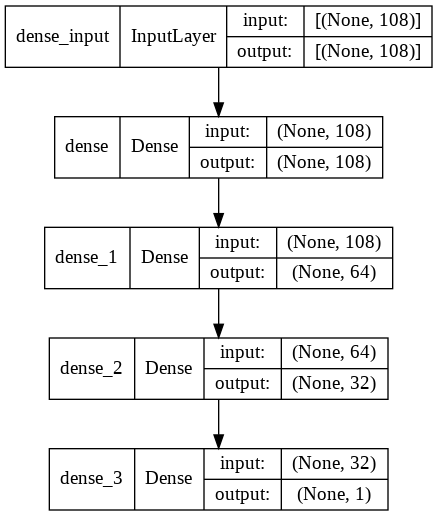

In [38]:
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [6]:
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

preds_valid_f = {}
preds_test = []
total_auc = []
f_scores = []

kf = StratifiedKFold(n_splits=FOLDS,random_state=0,shuffle=True)

for fold,(train_index, valid_index) in enumerate(kf.split(train,target)):

    X_train,X_valid = train.loc[train_index], train.loc[valid_index]
    y_train,y_valid = target.loc[train_index], target.loc[valid_index]

    #   --------------------------------------------------------  
    # Preprocessing
    index_valid  = X_valid.index.tolist()
    test  = raw_test.copy()
    
    X_train = preprocessor.fit_transform(X_train)
    X_valid = preprocessor.transform(X_valid)
    test = preprocessor.transform(test)
    
    #  ----------------------------------------------------------    
    # Model
    
    model, early_stopping, plateau  = load_model('version1')

    history = model.fit(  X_train, y_train,
                validation_data = (X_valid, y_valid),
                batch_size = BATCH_SIZE, 
                epochs = EPOCHS,
                callbacks = [early_stopping, plateau],
                shuffle = True,
                verbose = 0
              )

    #  ----------------------------------------------------------
    #  oof
    preds_valid = model.predict(X_valid).reshape(1,-1)[0] 
    
    #  ----------------------------------------------------------
    #  test  predictions
    preds_test.append(model.predict(test).reshape(1,-1)[0])
    
    #  ----------------------------------------------------------
    #  Saving  scores to plot the end  
    scores = pd.DataFrame(history.history)
    scores['folds'] = fold
    
    if fold == 0:
        f_scores = scores 
    else: 
        f_scores = pd.concat([f_scores, scores], axis  = 0)
        
    #  ----------------------------------------------------------
    #  concatenating valid preds
    preds_valid_f.update(dict(zip(index_valid, preds_valid)))

    # Getting score for a fold model
    fold_auc = roc_auc_score(y_valid, preds_valid)
    print(f"Fold {fold} roc_auc_score: {fold_auc}")

    # Total auc
    total_auc.append(fold_auc)

print(f"mean roc_auc_score: {np.mean(total_auc)}, std: {np.std(total_auc)}")

Fold 0 roc_auc_score: 0.7526256099026882
Fold 1 roc_auc_score: 0.7540331585697734
Fold 2 roc_auc_score: 0.7527269303667247
Fold 3 roc_auc_score: 0.7530722234215821
Fold 4 roc_auc_score: 0.7526974161444104
mean roc_auc_score: 0.7530310676810357, std: 0.0005242325453731733


Validation Loss: 0.5720
Validation Loss: 0.5687
Validation Loss: 0.5711
Validation Loss: 0.5685
Validation Loss: 0.5704


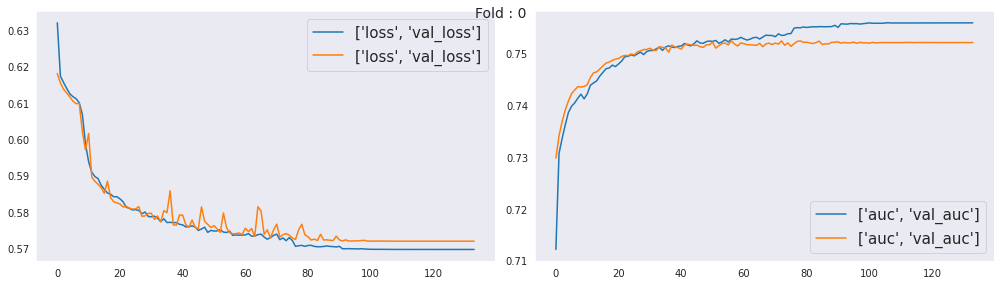

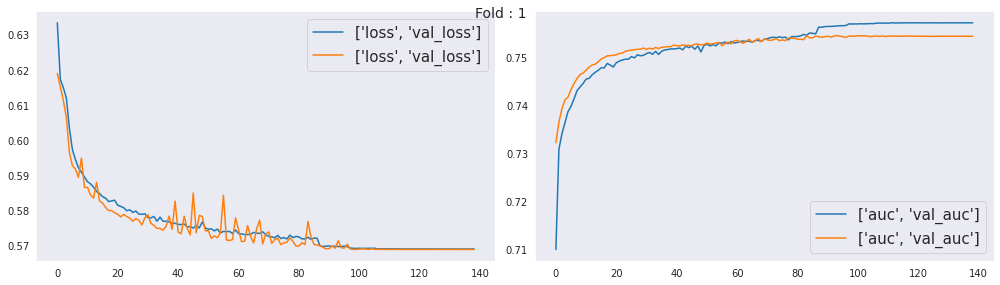

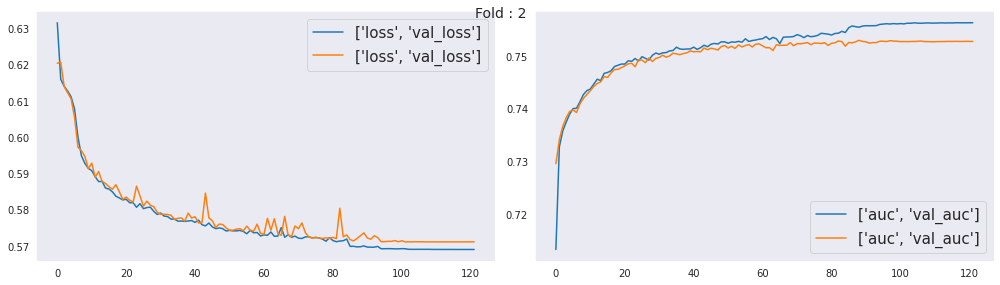

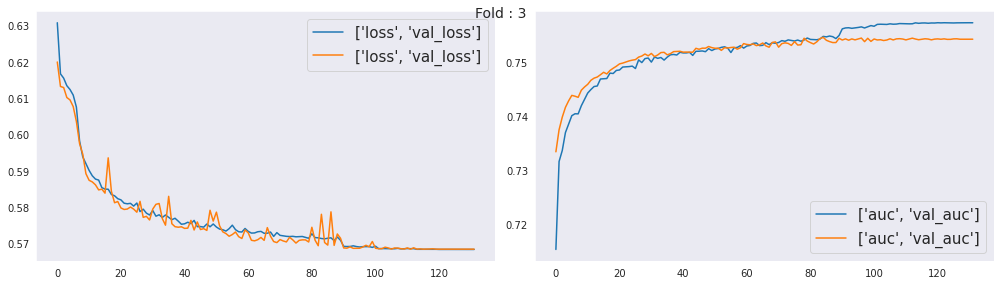

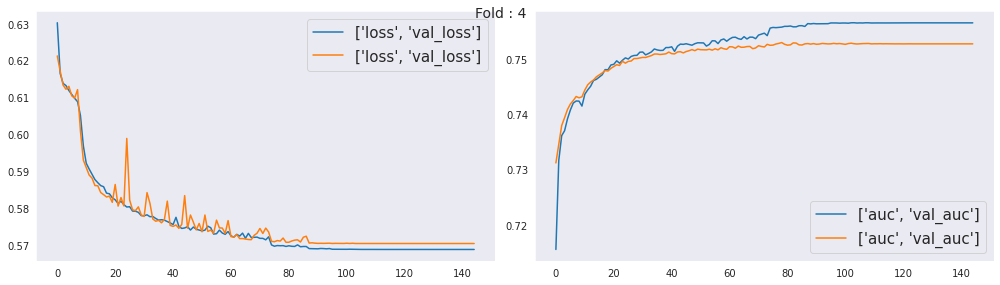

In [68]:
import matplotlib.pyplot as plt

for fold in range(f_scores['folds'].nunique()):
    history_f = f_scores[f_scores['folds'] == fold]

    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(14,4))
    fig.suptitle('Fold : '+str(fold), fontsize=14)
        
    plt.subplot(1,2,1)
    plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])
    plt.legend(fontsize=15)
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(history_f.loc[:, ['auc', 'val_auc']],label= ['auc', 'val_auc'])
    plt.legend(fontsize=15)
    plt.grid()
    
    print("Validation Loss: {:0.4f}".format(history_f['val_loss'].min()));

In [74]:
sub = pd.read_csv("./sample_submission.csv")
sub['target'] = np.mean(preds_test, axis = 0)
sub.to_csv('submission.csv', index=False)
sub.head()

,id,target
0,600000,0.741981
1,600001,0.742518
2,600002,0.763085
3,600003,0.443845
4,600004,0.720801


In [75]:
!kaggle competitions submit -c tabular-playground-series-nov-2021 -f submission.csv -m 'second submit'
sln("finish to submit")

100% 9.17M/9.17M [00:00<00:00, 25.1MB/s]
Successfully submitted to Tabular Playground Series - Nov 2021

Ref:
https://www.kaggle.com/javiervallejos/simple-nn-with-good-results-tps-nov-21